In [1]:
import duckdb
import pandas as pd

# Connetti al database DuckDB
con = duckdb.connect("../data/diabetes.duckdb")

# Query: distribuzione readmitted
df = con.execute("""
    SELECT readmitted, COUNT(*) as count
    FROM mart_readmission_analysis
    GROUP BY readmitted
    ORDER BY count DESC
""").fetchdf()

df

,readmitted,count
0,>30,109596
1,NO,75970
2,<30,44326


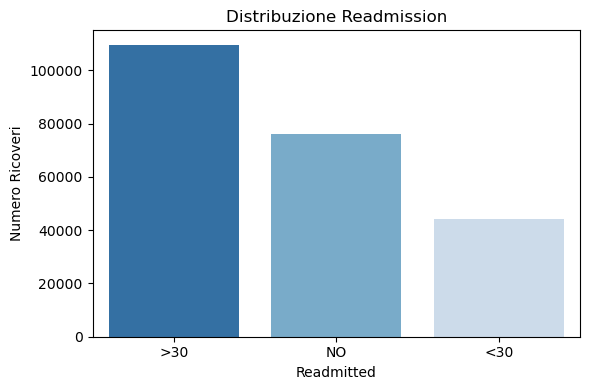

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='readmitted', y='count', palette='Blues_r')

plt.title("Distribuzione Readmission")
plt.ylabel("Numero Ricoveri")
plt.xlabel("Readmitted")
plt.tight_layout()
plt.show()

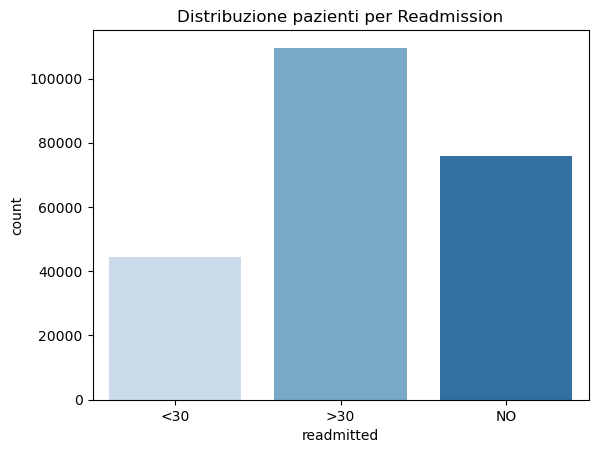

In [3]:
# Distribuzione riospedalizzazione
df_readmit = con.execute("""
    SELECT readmitted, COUNT(*) AS count
    FROM mart_readmission_analysis
    GROUP BY readmitted
""").fetchdf()

# Grafico
sns.barplot(data=df_readmit, x='readmitted', y='count', palette='Blues')
plt.title("Distribuzione pazienti per Readmission")
plt.show()

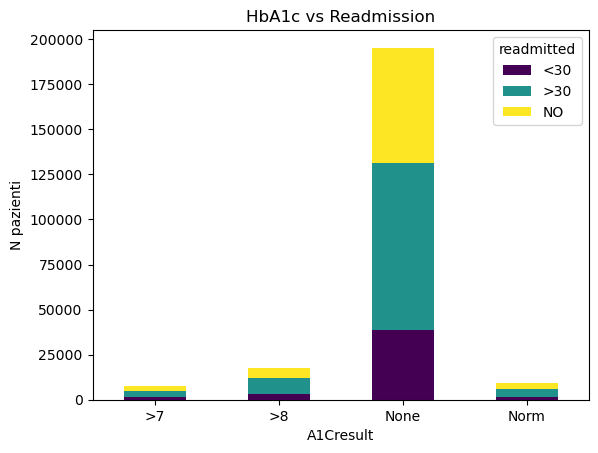

In [4]:
df_hba1c = con.execute("""
    SELECT A1Cresult, readmitted, COUNT(*) as count
    FROM mart_readmission_analysis
    GROUP BY A1Cresult, readmitted
    ORDER BY A1Cresult
""").fetchdf()

# Plot stacked barplot
pivot = df_hba1c.pivot(index='A1Cresult', columns='readmitted', values='count').fillna(0)
pivot.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("HbA1c vs Readmission")
plt.ylabel("N pazienti")
plt.xticks(rotation=0)
plt.show()

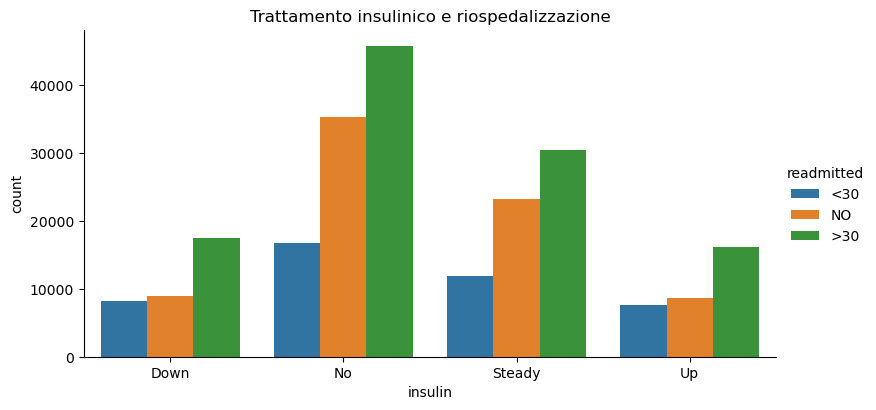

In [5]:
df_insulin = con.execute("""
    SELECT insulin, readmitted, COUNT(*) as count
    FROM mart_readmission_analysis
    GROUP BY insulin, readmitted
""").fetchdf()

sns.catplot(data=df_insulin, x='insulin', y='count', hue='readmitted', kind='bar', height=4, aspect=2)
plt.title("Trattamento insulinico e riospedalizzazione")
plt.show()

In [6]:
# Estrai dataset numerico per clustering
df_clust = con.execute("""
    SELECT 
        time_in_hospital,
        CASE WHEN A1Cresult = '>8' THEN 2
             WHEN A1Cresult = 'Norm' THEN 0
             WHEN A1Cresult = '>7' THEN 1
             ELSE -1 END AS hba1c_code,
        CASE WHEN insulin = 'Up' THEN 1
             WHEN insulin = 'Down' THEN -1
             WHEN insulin = 'No' THEN 0
             ELSE 2 END AS insulin_code
    FROM mart_readmission_analysis
    WHERE A1Cresult IS NOT NULL AND insulin IS NOT NULL
""").fetchdf()

df_clust.head()

,time_in_hospital,hba1c_code,insulin_code
0,5,-1,0
1,1,-1,2
2,1,-1,0
3,6,-1,0
4,6,-1,1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


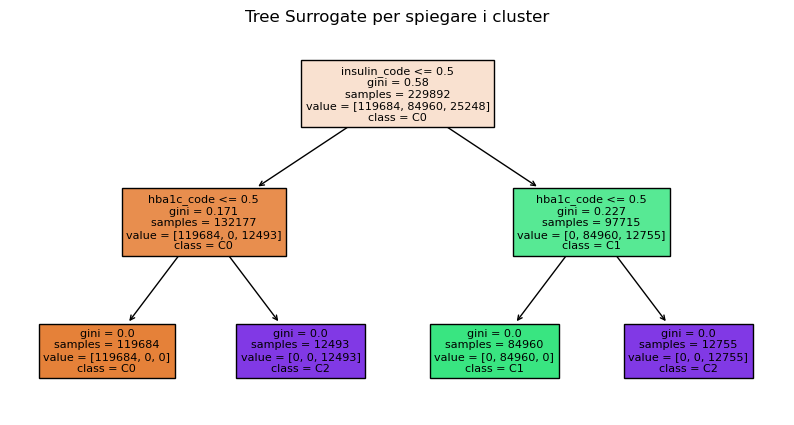

In [7]:
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler

# Scaling
X = StandardScaler().fit_transform(df_clust)

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)
df_clust['cluster'] = labels

# Explainability alternativa: Decision Tree Surrogate
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(df_clust.drop(columns='cluster'), df_clust['cluster'])

# Plot albero
plt.figure(figsize=(10, 5))
plot_tree(clf, feature_names=df_clust.columns[:-1], class_names=['C0', 'C1', 'C2'], filled=True)
plt.title("Tree Surrogate per spiegare i cluster")
plt.show()

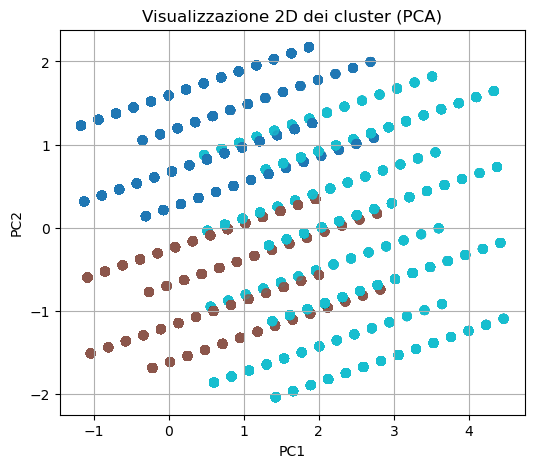

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(6, 5))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df_clust['cluster'], cmap='tab10', alpha=0.6)
plt.title("Visualizzazione 2D dei cluster (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [9]:
con.close()